# 机器学习期末大作业：基于VAE的手写数字生成

### 小组成员：
- 许渊轶-2013356-计算机科学与技术
- 蔡玉柱-2013540-信息安全
- 聂志强-2012307-信息安全

(成员分工写在本文件最后)

### 实验要求

1. 基本要求：利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；
2. 中级要求：实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；
3. 提高要求：实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）

### 导入相应包

In [2]:
# 需要提前安装Pytorch和对应版本的torchvision
import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
from scipy.stats import norm
from torch.optim import AdamW
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as pltorms
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from skimage.util import random_noise
import warnings
from torchvision.utils import save_image
from sklearn.preprocessing import LabelBinarizer
from matplotlib.image import imread
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

### 下载数据集

In [3]:
# 下载数据集
dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
batch_sz = 128   # 数据集切分，每个batch大小为128
dataIter = Data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)

In [5]:
# 查看张量的维度数：N(num),C(channel),H(height),W(width)
x, y = next(iter(dataIter))
x.shape  # torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

torch.Size([128, 1, 28, 28])

## 一. 基本要求

### 1. 完善VAE模型
补全其中的encode、reparameterize、decode和forward四个函数。在encode函数中直接调用relu激活函数以及已给出的fc1、fc2、fc3三种线性网络层编码获得所需的mu以及log_var变量。在reparameterize函数中利用这两个变量生成隐变量z。在decode函数中采用fc4、fc5线性网络层，结合relu和sigmoid激活函数解码得到输出output。最后在forward函数中实现编码->解码的前向传播过程。

In [6]:
# 简单建一个VAE
class VAE(nn.Module):
    def __init__(self, count_size = 784, h_dim=256, z_dim=20):  
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(count_size, h_dim)  # Encoder
        self.fc2 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc5 = nn.Linear(h_dim, count_size)  # output
    

    # 编码
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1), self.fc3(h1)

    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    # 解码
    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h3))

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

### 2. 实现损失函数
在接下来的中级要求中将会推导出VAE的损失函数：
$$
\text { Loss }=\frac{1}{n} \sum_{i=1}^n\left[\log p\left(x_i \mid z_i\right)+\frac{1}{2} \sum_{i=1}^d\left(-\log \sigma^2+\sigma^2+\mu^2-1\right)\right]
$$
可以看出其主要由两项构成，第一项由蒙特卡洛采样获得，可以采用交叉熵Loss、MSE Loss等来计算，我们将所采用的Loss作为一个参数reconstruction_function传入。第二项为由KL散度的知识计算出的损失，直接照着上面的式子计算即可。

In [7]:
def loss_function(recon_x, x, mu, logvar,reconstruction_function):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

### 3. 使用MSE Loss训练模型。
我们设置学习率为10e-3，epoches为20，按照默认参数实例化出模型和优化器，采用MSE Loss训练，进行反向传播和优化等等。可以看到训练完成后的loss在32~33左右

In [103]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备

learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 41.33180618286133
epoch : 0 | #batch : 400 | batch average loss: 34.949649810791016
epoch[0/20] | loss:42.637129325358075
epoch : 1 | #batch : 200 | batch average loss: 35.62492752075195
epoch : 1 | #batch : 400 | batch average loss: 32.27069854736328
epoch[1/20] | loss:34.896050390625
epoch : 2 | #batch : 200 | batch average loss: 33.18363952636719
epoch : 2 | #batch : 400 | batch average loss: 35.72508239746094
epoch[2/20] | loss:33.905175423177084
epoch : 3 | #batch : 200 | batch average loss: 33.33106994628906
epoch : 3 | #batch : 400 | batch average loss: 33.75284957885742
epoch[3/20] | loss:33.53584141031901
epoch : 4 | #batch : 200 | batch average loss: 33.32897186279297
epoch : 4 | #batch : 400 | batch average loss: 34.00872802734375
epoch[4/20] | loss:33.32682939046224
epoch : 5 | #batch : 200 | batch average loss: 34.477500915527344
epoch : 5 | #batch : 400 | batch average loss: 33.10856246948242
epoch[5/20] | loss:33.19527693684

此时也可展示训练过程中Loss的变化

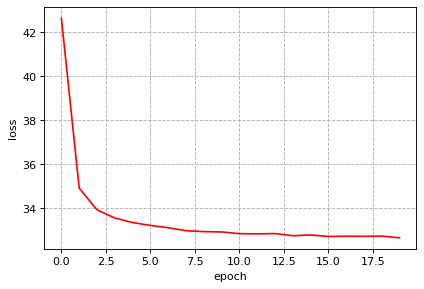

In [104]:
plt.figure(figsize=(6,4),dpi=80)
plt.plot(range(len(train_loss)),train_loss, 'r')
plt.grid(linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

展示训练结果：我们从正态分布中随机采样隐变量z，将其解码获得生成的数字图片。再将图片以6x6的格式进行展示。可以看出图片有些模糊，但能辨认出生成的数字，且所有数字都可生成

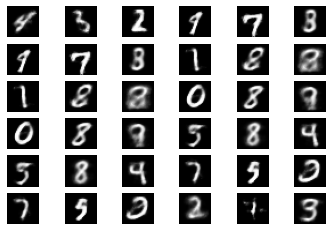

In [105]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

### 4. 使用BCE Loss训练模型
与MSE Loss时保持一致，我们设置学习率为10e-3，epoches为20，按照默认参数实例化出模型和优化器，采用BCE(Binary Cross Entropy) Loss训练，进行反向传播和优化等等。此时训练完后的Loss大约为115

In [106]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用BCE loss
reconstruction_function = nn.BCELoss(reduction="sum")

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 149.8361053466797
epoch : 0 | #batch : 400 | batch average loss: 127.70418548583984
epoch[0/20] | loss:157.94174477539062
epoch : 1 | #batch : 200 | batch average loss: 120.98452758789062
epoch : 1 | #batch : 400 | batch average loss: 120.58049011230469
epoch[1/20] | loss:126.79339568684895
epoch : 2 | #batch : 200 | batch average loss: 118.80414581298828
epoch : 2 | #batch : 400 | batch average loss: 122.50570678710938
epoch[2/20] | loss:123.8644930501302
epoch : 3 | #batch : 200 | batch average loss: 116.25100708007812
epoch : 3 | #batch : 400 | batch average loss: 124.28958129882812
epoch[3/20] | loss:121.47744099934896
epoch : 4 | #batch : 200 | batch average loss: 118.8524398803711
epoch : 4 | #batch : 400 | batch average loss: 127.18086242675781
epoch[4/20] | loss:120.20917412109375
epoch : 5 | #batch : 200 | batch average loss: 117.78974914550781
epoch : 5 | #batch : 400 | batch average loss: 118.218994140625
epoch[5/20] | loss:119.

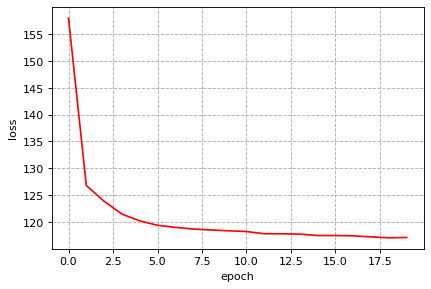

In [107]:
plt.figure(figsize=(6,4),dpi=80)
plt.plot(range(len(train_loss)),train_loss, 'r')
plt.grid(linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

展示训练结果：我们从正态分布中随机采样隐变量z，将其解码获得生成的数字图片。再将图片以6x6的格式进行展示。可以看出图片质量比MSE Loss时略差，但仍能辨认出生成的数字，且所有数字都可生成

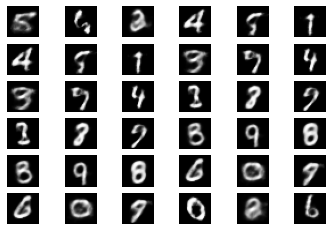

In [108]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

### 5. 使用CE Loss训练模型
此时我们发现设置学习率为10e-3时效果极差，易出现过拟合，因此修改学习率为10e-4。epoches仍为20，按照默认参数实例化出模型和优化器，采用CE(Cross Entropy) Loss训练，进行反向传播和优化等等。此时训练完后的Loss大约为630左右

In [109]:
learning_rate = 10e-4  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用交叉熵 loss
reconstruction_function = nn.CrossEntropyLoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 636.000244140625
epoch : 0 | #batch : 400 | batch average loss: 609.1724243164062
epoch[0/20] | loss:638.3506389973958
epoch : 1 | #batch : 200 | batch average loss: 678.4329223632812
epoch : 1 | #batch : 400 | batch average loss: 635.228515625
epoch[1/20] | loss:633.912549609375
epoch : 2 | #batch : 200 | batch average loss: 652.0982055664062
epoch : 2 | #batch : 400 | batch average loss: 640.15185546875
epoch[2/20] | loss:632.9139971354167
epoch : 3 | #batch : 200 | batch average loss: 628.1046752929688
epoch : 3 | #batch : 400 | batch average loss: 646.1024780273438
epoch[3/20] | loss:632.5987717447916
epoch : 4 | #batch : 200 | batch average loss: 638.25732421875
epoch : 4 | #batch : 400 | batch average loss: 634.5590209960938
epoch[4/20] | loss:632.4546388020833
epoch : 5 | #batch : 200 | batch average loss: 647.286376953125
epoch : 5 | #batch : 400 | batch average loss: 621.4144897460938
epoch[5/20] | loss:632.3494363932292
epoch : 6

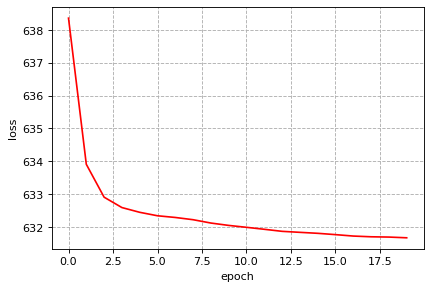

In [110]:
plt.figure(figsize=(6,4),dpi=80)
plt.plot(range(len(train_loss)),train_loss, 'r')
plt.grid(linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

展示训练结果：我们从正态分布中随机采样隐变量z，将其解码获得生成的数字图片。再将图片以6x6的格式进行展示。可以看出图片质量是三种Loss下最差的，有些数字甚至难以辨认，相对而言笔画更为粗糙。综上所述，我们更推荐VAE采用MSE或BCE Loss，而不推荐使用单纯的CE Loss

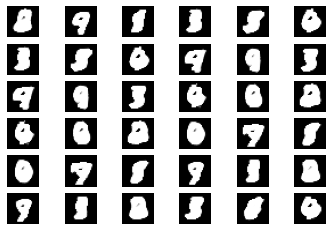

In [111]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

## 二. 中级要求

### 1. 实现VAE的变分推断


    VAE的重点在于建模 Z 服从的分布，因为知道了 Z 的分布，我们就可以从其中进行采样，重建输入 X 。由于隐变量 Z 同输入 X 是紧密相关的，因此我们假设：
$$
z \sim p(z \mid x)
$$
    绝大数情况下，我们所拥有的数据是非常有限的，导致这个真实分布总是未知的，因此我们希望基于已有的数据，通过一个神经网络即编码器来近似该分布，假设为：
$$
z \sim q(z \mid x)
$$
    通过KL散度来衡量这两个分布的差异，即目的转化为最小化下列式子：
$$
K L(q(z \mid x) \| p(z \mid x))=\int q(z \mid x) \log \frac{q(z \mid x)}{p(z \mid x)} d z
$$
    对上式进行变换：
$$
\begin{aligned}
原式 & =\int q(z \mid x) \log \frac{q(z \mid x)}{\frac{p(x \mid z z) p(z)}{p(x)}} d z \\
& =\int q(z \mid x) \log q(z \mid x) d z+\int q(z \mid x) \log p(x) d z-\int q(z \mid x) \log [p(x \mid z) p(z)] d z \\
& =\int q(z \mid x) \log q(z \mid x) d z+\log p(x) \int q(z \mid x) d z-\int q(z \mid x) \log [p(x \mid z) p(z)] d z \text { (注意 } \int q(z \mid x) d z=1 \text { ) } \\
& =\log p(x)+\int q(z \mid x) \log q(z \mid x) d z-\int q(z \mid x) \log [p(x \mid z) p(z)] d z \text { (把第二项提前) }
\end{aligned}
$$
    最小化这个式子，等价于最大化下式，也就是ELBO
$$
\begin{aligned}
Loss & =\int q(z \mid x) \log [p(x \mid z) p(z)] d z-\int q(z \mid x) \log q(z \mid x) d z \\
& =\int q(z \mid x) \log p(x \mid z) d z+\int q(z \mid x) \log p(z) d z-\int q(z \mid x) \log q(z \mid x) d z \\
& =E_z \text { 服从 } q(z \mid x)[\log p(x \mid z)]-D_{K L}(q(z \mid x) \| p(z))
\end{aligned}
$$
    分析ELBO，第一项即为不断的从样本x确定的分布Z中不断的采样一个z，希望从z重建输入x的期望最大，因此p(x∣z)即为解码器，由于期望不好直接求，我们可以将该问题专化为求损失，对于分类问题，E为交叉熵损失，对于连续值问题，E为MSE损失。
    ELBO的第二项为由x生成Z的分布（论文中假设服从高斯分布）同真实Z的分布之间的差异，p(z)的真实分布是未知的，论文中假设p(z)服从一个标准正态分布，从神经网络的角度看，可以认为第二项为一个正则项，对编码器进行约束，防止采样结果过于极端，导致生产的图像不真实。
    对这个第二项进行化简，其中d是Z的维度：
$$
\begin{aligned}
\int q_{\boldsymbol{\theta}}(\mathbf{z}) \log p(\mathbf{z}) d \mathbf{z} & =\int \mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}, \boldsymbol{\sigma}^2\right) \log \mathcal{N}(\mathbf{z} ; \mathbf{0}, \mathbf{I}) d \mathbf{z} \\
& =-\frac{d}{2} \log (2 \pi)-\frac{1}{2} \sum_{i=1}^d\left(\mu_j^2+\sigma_j^2\right)
\end{aligned}
$$
$$
\begin{aligned}
\int q_\theta(\mathbf{z}) \log q_{\boldsymbol{\theta}}(\mathbf{z}) d \mathbf{z} & =\int \mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}, \boldsymbol{\sigma}^2\right) \log \mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}, \boldsymbol{\sigma}^2\right) d \mathbf{z} \\
& =-\frac{d}{2} \log (2 \pi)-\frac{1}{2} \sum_{i=1}^d\left(1+\log \sigma^2\right)
\end{aligned}
$$
    所以有：
$$
\begin{aligned}
-D_{K L}\left(\left(q_\phi(\mathbf{z}) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)\right. & =\int q_\theta(\mathbf{z})\left(\log p_\theta(\mathbf{z})-\log q_\theta(\mathbf{z})\right) d \mathbf{z} \\
& =\frac{1}{2} \sum_{i=1}^d\left(1+\log \left(\left(\sigma\right)^2\right)-\left(\mu\right)^2-\left(\sigma\right)^2\right)
\end{aligned}
$$ 
    所以：
$$
Loss=\frac{1}{n} \sum_{i=1}^n\left[\log p\left(x_i \mid z_i\right)+\frac{1}{2} \sum_{i=1}^d\left(-\log \sigma^2+\sigma^2+\mu^2-1\right)\right]
$$

### 2. VAE的由来

    变分自编码器(VAE)是一种生成模型，它“提供潜在空间中观察结果的概率描述”，将潜在属性存储为概率分布，VAE的思想植根于变分贝叶斯和图形模型方法。变分自编码器具有连续的潜在空间，这样可以使随机采样和插值更加方便。为了实现这一点，编码器的隐藏节点不输出编码向量，而是输出两个大小相同的向量:一个均值向量和一个标准差向量。每一个隐藏的节点都认为自己是高斯分布的。这里的均值和标准差向量的第i个元素对应第i个随机变量的均值和标准差值。我们从这个分布向量中采样，解码器从输入向量的概率分布中随机抽样，这个过程就是随机生成。这意味着即使对于相同的输入，当平均值和标准差保持不变时，实际的编码在每一次传递中都会有所不同。

### 3. VAE优缺点
    (1) VAE优点：可逆且高效，相对基于流程的模型更具有更快时间和更好的参数效率。
    (2) VAE缺点：生成的输出模糊。VAE模型往往产生不现实的、模糊的样本，这是由数据分布恢复和损失函数计算的方式造成的，改进策略可以不使用变分贝叶斯方法来提高输出质量。

## 三. 提高要求

### 1. 生成对抗网络(GAN)对比

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
# 生成器，基于线性层
class G_net(nn.Module):
    def __init__(self):
        super(G_net,self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            # 将输出约束到[-1,1]
            nn.Tanh()
        )

    def forward(self, img_seeds):
        output = self.gen(img_seeds)
        # 将线性数据重组为二维图片
        output = output.view(-1, 1, 28, 28)
        return output


# 根据生成器的配置返回对应的模型
def get_G_model(device):
    model = G_net()
    # 将模型加载到用于运算的设备的内存
    model = model.to(device)

    return model


# 判别器
class D_net(nn.Module):
    def __init__(self):
        super(D_net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(36864, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        # 提取特征
        features = self.features(img)
        # 展平二维矩阵
        features = features.view(features.shape[0],-1)
        # 使用线性层分类
        output = self.classifier(features)
        return output


# 返回判别器的模型
def get_D_model(device):
    model = D_net()
    # 将模型加载到用于运算的设备的内存
    model = model.to(device)

    return model

定义G和D的优化器，此处使用AdamW优化器，学习率为1e-4，损失函数采用交叉熵损失函数

In [31]:
epoches = 20  

G_model = get_G_model(device)
D_model = get_D_model(device)

G_optimizer = AdamW(G_model.parameters(), lr=1e-4, weight_decay=1e-6)
D_optimizer = AdamW(D_model.parameters(), lr=1e-4, weight_decay=1e-6)

criterion = nn.BCELoss()

训练过程：
- 从dataIter中提取数据
- 训练判断器D <br/>
用真样本输入判别器；对于数据集末尾的数据，长度不够一个batch size时需要去除过长的真实标签；用假样本输入判别器；将真样本与假样本损失相加，得到判别器的损失
<br/>
- 训练生成器G <br/>
将随机种子数喂入生成器G生成假数据并输入判别器； 
将假数据的判别结果与真实标签对比得到损失；
利用损失更新生成器G
<br/>

In [32]:
G_loss_total=[]
for epoch in range(epoches):
    batch_num = len(dataIter)
    D_loss_sum = 0
    G_loss_sum = 0
    count = 0

    for index, data in enumerate(dataIter):
        count += 1
        # 将图片放入运算设备的内存
        images, _ = data
        images = images.to(device)

        # 定义真标签，使用标签平滑的策略，生成0.9到1之间的随机数作为真实标签
        real_labels = (1 - torch.rand(batch_sz, 1)/10).to(device)
        # 定义假标签，单向平滑，因此不对生成器标签进行平滑处理，全0
        fake_labels = Variable(torch.zeros(batch_sz, 1)).to(device)
        # 将随机的初始数据喂入生成器生成假图像
        img_seeds = torch.randn(batch_sz, 256).to(device)
        fake_images = G_model(img_seeds)
        # 记录真假标签是否被交换过
        exchange_labels = False
        # 有一定概率在训练判别器时交换label
        if random.uniform(0, 1) < 0.05:
            real_labels, fake_labels = fake_labels, real_labels
            exchange_labels = True

        D_optimizer.zero_grad()
        real_output = D_model(images)
        if len(real_labels) > len(real_output):
            D_loss_real = criterion(real_output, real_labels[:len(real_output)])
        else:
            D_loss_real = criterion(real_output, real_labels)
        fake_output = D_model(fake_images)
        D_loss_fake = criterion(fake_output, fake_labels)
        D_loss = D_loss_real + D_loss_fake
        D_loss_sum += D_loss.item()
        # 重置优化器
        D_optimizer.zero_grad()
        # 用损失更新判别器D
        D_loss.backward()
        D_optimizer.step()
        # 如果之前交换过标签，此时再换回来
        if exchange_labels:
            real_labels, fake_labels = fake_labels, real_labels

        img_seeds = torch.randn(batch_sz, 256).to(device)
        fake_images = G_model(img_seeds)
        fake_output = D_model(fake_images)
        G_loss = criterion(fake_output, real_labels)
        G_loss_sum += G_loss.item()
        # 重置优化器
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (index + 1) % 200 == 0:
            print("Epoch: %2d, Batch: %4d / %4d" % (epoch + 1, index + 1, batch_num))
    G_loss_total.append( round(G_loss_sum / count, 3))
    print("epoch[{}/{}] | D_loss:{} | G_loss:{}"
          .format(epoch+1, epoches, round(D_loss_sum / count, 3), round(G_loss_sum / count, 3)))

Epoch:  1, Batch:  200 /  469
Epoch:  1, Batch:  400 /  469
epoch[1/20] | D_loss:0.672 | G_loss:5.085
Epoch:  2, Batch:  200 /  469
Epoch:  2, Batch:  400 /  469
epoch[2/20] | D_loss:0.662 | G_loss:3.832
Epoch:  3, Batch:  200 /  469
Epoch:  3, Batch:  400 /  469
epoch[3/20] | D_loss:0.656 | G_loss:3.061
Epoch:  4, Batch:  200 /  469
Epoch:  4, Batch:  400 /  469
epoch[4/20] | D_loss:0.611 | G_loss:3.043
Epoch:  5, Batch:  200 /  469
Epoch:  5, Batch:  400 /  469
epoch[5/20] | D_loss:0.658 | G_loss:2.764
Epoch:  6, Batch:  200 /  469
Epoch:  6, Batch:  400 /  469
epoch[6/20] | D_loss:0.649 | G_loss:2.754
Epoch:  7, Batch:  200 /  469
Epoch:  7, Batch:  400 /  469
epoch[7/20] | D_loss:0.716 | G_loss:2.473
Epoch:  8, Batch:  200 /  469
Epoch:  8, Batch:  400 /  469
epoch[8/20] | D_loss:0.667 | G_loss:2.686
Epoch:  9, Batch:  200 /  469
Epoch:  9, Batch:  400 /  469
epoch[9/20] | D_loss:0.693 | G_loss:2.658
Epoch: 10, Batch:  200 /  469
Epoch: 10, Batch:  400 /  469
epoch[10/20] | D_loss:

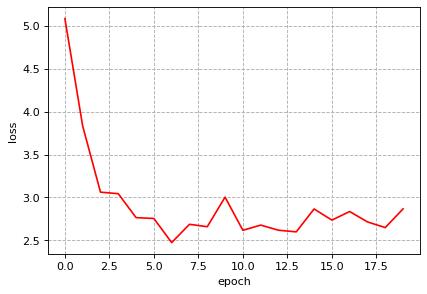

In [33]:
plt.figure(figsize=(6,4),dpi=80)
plt.plot(range(len(G_loss_total)),G_loss_total, 'r')
plt.grid(linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

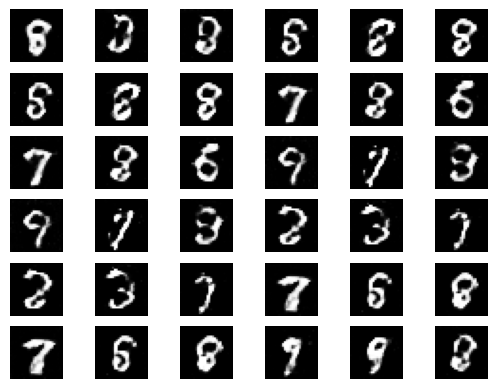

In [34]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn(batch_sz, 256).to(device)
logits = G_model(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

根据测试生成的图像对比VAE可以得出，GAN生成的效果优于VAE。VAE和GAN很大的一个区别在于loss，VAE是pointwise loss，一个典型的特征就是pointwise loss常常会脱离数据流形面，因此看起来生成的图片会模糊GAN是分布匹配的loss，更能贴近流行面，所以看起来就会清晰。

### 2. $\beta-VAE$

$\beta-VAE$的目标是学习独立的特征，让某种特征对应某个生成因素，而独立于其他因素。而解决的办法即通过在原始的损失函数的KL项引入惩罚$\beta$，得到如下式子：
$$
\mathcal{F}(\theta, \phi, \beta ; \mathbf{x}, \mathbf{z}) \geq \mathcal{L}(\theta, \phi ; \mathbf{x}, \mathbf{z}, \beta)=\mathbb{E}_{q \phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\beta D_{K L}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z})\right)
$$

In [23]:
reconstruction_function = nn.MSELoss(size_average=False)

def beta_loss_function(recon_x, x, mu, logvar, beta):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + beta * KLD

In [24]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次
beta = 0.8

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = beta_loss_function(recon_batch, img, mu, log_var, beta)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 36.907081604003906
epoch : 0 | #batch : 400 | batch average loss: 33.133384704589844
epoch[0/20] | loss:39.9695193359375
epoch : 1 | #batch : 200 | batch average loss: 31.94214630126953
epoch : 1 | #batch : 400 | batch average loss: 32.13774108886719
epoch[1/20] | loss:32.089324088541666
epoch : 2 | #batch : 200 | batch average loss: 31.284832000732422
epoch : 2 | #batch : 400 | batch average loss: 30.2257080078125
epoch[2/20] | loss:31.183488692220052
epoch : 3 | #batch : 200 | batch average loss: 31.06804084777832
epoch : 3 | #batch : 400 | batch average loss: 30.873249053955078
epoch[3/20] | loss:30.81416346842448
epoch : 4 | #batch : 200 | batch average loss: 30.00872039794922
epoch : 4 | #batch : 400 | batch average loss: 29.121524810791016
epoch[4/20] | loss:30.60336211344401
epoch : 5 | #batch : 200 | batch average loss: 30.350261688232422
epoch : 5 | #batch : 400 | batch average loss: 30.717674255371094
epoch[5/20] | loss:30.530999

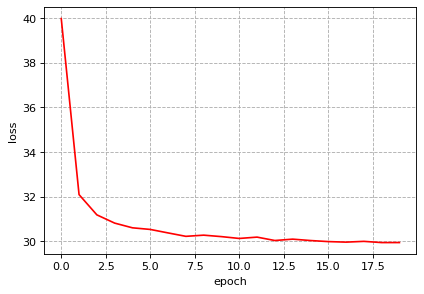

In [25]:
plt.figure(figsize=(6,4),dpi=80)
plt.plot(range(len(train_loss)),train_loss, 'r')
plt.grid(linestyle="--")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

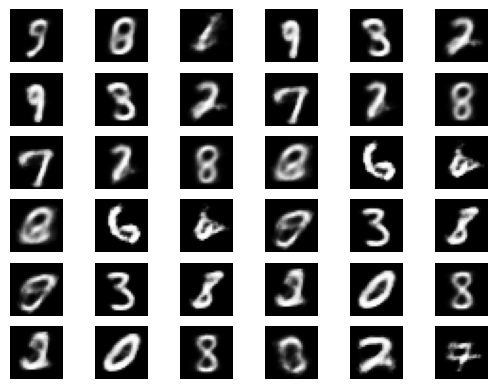

In [28]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

可以发现，引入了$\beta-VAE$后，VAE然能够学习到很好的特征，损失变少了，手写的数字也更为清晰。

### 3. CVAE

Conditional Variational Autoencoder(CVAE)是Variational Autoencoder(VAE)的扩展，在VAE中没有办法对生成的数据加以限制，所以如果在VAE中想生成特定的数据是办不到的。比如在mnist手写数字中，我们想生成特定的数字2，VAE就无能为力了。 因此，CVAE通过对潜层变量和输入数据施加约束，可以生成在某种约束条件下的数据。
在VAE中目标函数如下所示：
$$
\log P(X)-D_{K L}[Q(z \mid X) \| P(z \mid X)]=E[\log P(X \mid z)]-D_{K L}[Q(z \mid X) \| P(z)]
$$
这个目标函数（主要考虑变分下界）要使输入数据经过编码后的潜层变量的分布尽量服从某种先验分布P(Z),并且最小化重建损失。在这个模型中，编码器直接基于输入X来建模潜层变量z，而不考虑潜层输入X的类型（标签），解码器直接基于潜层变量z来重建X，假设得到X1，并没有将要获得那种类型的X1考虑在内。

对VAE进行改进使其可以基于某种约束来生成对应的样本。以mnist手写数字为例，将数字的标签y考虑在内，即编码器为Q(z|X, y), 解码器为P(X|z, y)。上述模型可以写成下面的形式:
$$
\log P(X \mid y)-D_{K L}[Q(z \mid X, y) \| P(z \mid X, y)]=E[\log P(X \mid z, y)]-D_{K L}[Q(z \mid X, y) \| P(z \mid y)]
$$
潜层变量z的分布变成了条件概率分布P(z|X,y), 对解码器来说生成的样本也变成了条件概率分布Q(X|z, y)。

本例使用mnist数据集，在VAE的基础上将标签y进行one-hot编码，之后和数据样本进行连接作为输入，在解码时，将潜层变量z和标签y的one-hot编码进行连接，以这种方式实现上述的条件概率分布。

In [5]:
from torchvision import datasets
BATCH_SIZE = 64
EPOCH = 20
SEED = 8

no_cuda = False
cuda_available = not no_cuda and torch.cuda.is_available()
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda_available else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda_available else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [6]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        self.fc1 = nn.Linear(794, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(30, 400)
        self.fc4 = nn.Linear(400, 794)
        
        self.lb = LabelBinarizer()
    #将标签进行one-hot编码
    def to_categrical(self, y: torch.FloatTensor):
        y_n = y.numpy()
        self.lb.fit(list(range(0,10)))
        y_one_hot = self.lb.transform(y_n)
        floatTensor = torch.FloatTensor(y_one_hot)
        return floatTensor
        
    def encode(self, x, y):
        y_c = self.to_categrical(y)
        #输入样本和标签y的one-hot向量连接
        con = torch.cat((x, y_c), 1)
        h1 = F.relu(self.fc1(con))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        #训练时使用重参数化技巧，测试时不用。（测试时应该可以用）
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z, y):
        y_c = self.to_categrical(y)
        #解码器的输入：将z和y的one-hot向量连接
        cat = torch.cat((z, y_c), 1)
        h3 = F.relu(self.fc3(cat))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 784), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model = CVAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def train(epoch):
    #Sets the module in training mode.
    model.train()
    train_loss = 0

#     batch_idx, (data, label) =enumerate(train_loader).__next__()
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device) #[64, 1, 28, 28]
        
        optimizer.zero_grad()
        label = label.to(device)
        recon_batch, mu, logvar = model(data, label)
#         print(recon_batch.shape) #[64, 794]
        #训练样本展平，在每个样本后面连接标签的one-hot向量
        flat_data = data.view(-1, data.shape[2]*data.shape[3])
#         print(data.shape, flat_data.shape)
        y_condition = model.to_categrical(label)
        con = torch.cat((flat_data, y_condition), 1)
        
        loss = loss_function(recon_batch, con, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [21]:
index, (data, label) =enumerate(train_loader).__next__()
print(index, data.shape, label.shape)

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


In [22]:
for epoch in range(1, EPOCH + 1):
    train(epoch)
    with torch.no_grad():
        #采样过程
        sample = torch.randn(64, 20).to(device)
      
        c = np.zeros(shape=(sample.shape[0],))
        rand = np.random.randint(0, 10)
        print(f"Random number: {rand}")
        c[:] = rand
        c = torch.FloatTensor(c)
        sample = model.decode(sample, c).cpu()
        #模型的输出矩阵：每一行的末尾都加了one-hot向量，要去掉这个one-hot向量再转换为图片。
        generated_image = sample[:, 0:sample.shape[1]-10]
        
        
        save_image(generated_image.view(64, 1, 28, 28),
                   'sample_' + str(epoch) + '.png')

epoch: 1 Average loss: 98.2932
Random number: 8
epoch: 2 Average loss: 98.1509
Random number: 3
epoch: 3 Average loss: 98.0189
Random number: 6
epoch: 4 Average loss: 97.9627
Random number: 4
epoch: 5 Average loss: 97.8751
Random number: 2
epoch: 6 Average loss: 97.7784
Random number: 0
epoch: 7 Average loss: 97.7125
Random number: 1
epoch: 8 Average loss: 97.6286
Random number: 6
epoch: 9 Average loss: 97.5622
Random number: 0
epoch: 10 Average loss: 97.4650
Random number: 2
epoch: 11 Average loss: 97.3761
Random number: 9
epoch: 12 Average loss: 97.3584
Random number: 6
epoch: 13 Average loss: 97.2647
Random number: 8
epoch: 14 Average loss: 97.1972
Random number: 7
epoch: 15 Average loss: 97.1368
Random number: 6
epoch: 16 Average loss: 97.0919
Random number: 3
epoch: 17 Average loss: 97.0494
Random number: 5
epoch: 18 Average loss: 96.9547
Random number: 5
epoch: 19 Average loss: 96.8951
Random number: 8
epoch: 20 Average loss: 96.8467
Random number: 7


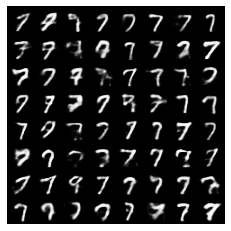

In [23]:
img = imread('sample_20.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### 4. 修改数据集

#### 本环节中我们采用了**添加噪点、中心切割、亮度改变、图片旋转**等多种方式来改变训练集中的图片，探究生成手写数字的图片收到哪些因素的影响。

#### (1) 我们采用添加噪点的方式对原始训练集中的数据添加变动。大致效果如下图所示。

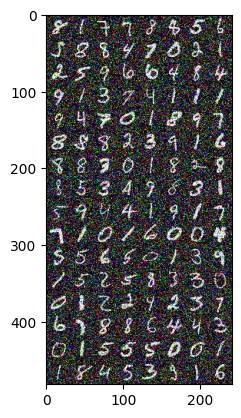

In [7]:
img,_ = next(iter(dataIter))
img = torchvision.utils.make_grid(img)
img = img.numpy().transpose(1, 2, 0)
image = random_noise(img,mode="gaussian",var=0.2,clip=True)
plt.imshow(image)
plt.show()

接下来的所有设置继承自“基本要求”中MSE Loss下的设置。唯一的变动在于在训练时采用random_noise函数以gaussian噪声的形式为采样的图片添加了噪点。由于添加的噪点较少（var=0.05），因此训练过程中的Loss只有小幅度的上涨

In [11]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # 添加噪点（少）
        img = random_noise(img,mode="gaussian",var=0.05)
        img = torch.tensor(img,dtype=torch.float32)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 51.386512756347656
epoch : 0 | #batch : 400 | batch average loss: 48.88679885864258
epoch[0/20] | loss:51.24184650878906
epoch : 1 | #batch : 200 | batch average loss: 49.87809753417969
epoch : 1 | #batch : 400 | batch average loss: 50.02419662475586
epoch[1/20] | loss:49.40797054036458
epoch : 2 | #batch : 200 | batch average loss: 47.596160888671875
epoch : 2 | #batch : 400 | batch average loss: 49.55128860473633
epoch[2/20] | loss:49.28488177083333
epoch : 3 | #batch : 200 | batch average loss: 49.77732849121094
epoch : 3 | #batch : 400 | batch average loss: 48.70878601074219
epoch[3/20] | loss:49.18524919433594
epoch : 4 | #batch : 200 | batch average loss: 50.168304443359375
epoch : 4 | #batch : 400 | batch average loss: 50.02435302734375
epoch[4/20] | loss:49.10830509440104
epoch : 5 | #batch : 200 | batch average loss: 47.31769561767578
epoch : 5 | #batch : 400 | batch average loss: 50.548526763916016
epoch[5/20] | loss:49.061819661

展示训练结果：可以看出相比于此前未添加噪点时生成的数字，此时生成的数字图片更加模糊，且数字的质量较差、种类较少，说明即使是很少的噪点，对于VAE的手写数字生成的效果也会产生较大的影响。

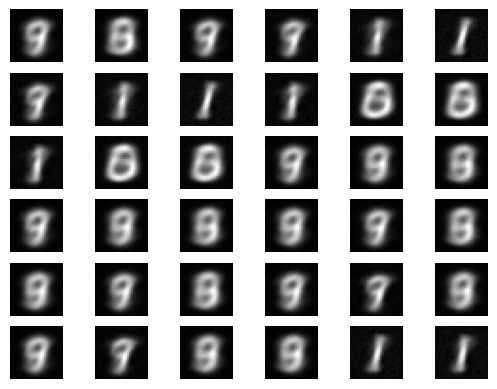

In [12]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

为了进行对比，我们再设置一个添加了更多噪点（var=0.5）的对照组。除了噪点外的其他设置与上文相同。可以看到添加了更多噪点后训练过程中的Loss大幅增长，预示训练结果将收到负面影响。

In [13]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # 添加噪点（多）
        img = random_noise(img,mode="gaussian",var=0.5)
        img = torch.tensor(img,dtype=torch.float32)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 109.43354797363281
epoch : 0 | #batch : 400 | batch average loss: 108.4077377319336
epoch[0/20] | loss:109.45735362955729
epoch : 1 | #batch : 200 | batch average loss: 108.73187255859375
epoch : 1 | #batch : 400 | batch average loss: 108.90882110595703
epoch[1/20] | loss:108.76745405273438
epoch : 2 | #batch : 200 | batch average loss: 108.23204040527344
epoch : 2 | #batch : 400 | batch average loss: 108.48685455322266
epoch[2/20] | loss:108.71935428059896
epoch : 3 | #batch : 200 | batch average loss: 108.37847137451172
epoch : 3 | #batch : 400 | batch average loss: 109.1300277709961
epoch[3/20] | loss:108.69769682617188
epoch : 4 | #batch : 200 | batch average loss: 107.94608306884766
epoch : 4 | #batch : 400 | batch average loss: 108.01934814453125
epoch[4/20] | loss:108.66785481770833
epoch : 5 | #batch : 200 | batch average loss: 109.26689910888672
epoch : 5 | #batch : 400 | batch average loss: 108.51083374023438
epoch[5/20] | loss:1

展示训练结果：我们可以看到随着噪点的增多，生成的数字的质量也会下降，并且最后变得只能生成一种数字，这是收到噪声干扰的结果。可见如果要进行手写数字生成的训练，在预处理中需要保证训练集图片的噪点尽可能少。

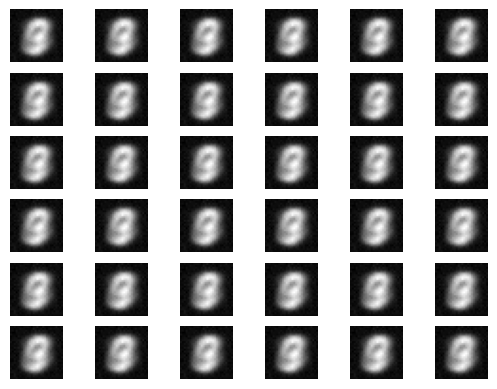

In [14]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

#### (2) 中心切割。我们将训练集中图片由原本的28x28切割为20x20，保留并突出了中间的数字部分。大致效果如下图所示：

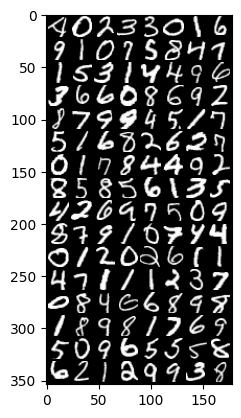

In [15]:
img,_ = next(iter(dataIter))
cc_obj = transforms.CenterCrop((20,20))
img = cc_obj(img)
img = torchvision.utils.make_grid(img)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()

此时模型的设置大体仍沿用“基本要求”中MSE Loss下的设置。但VAE模型中对应输入图片尺寸的参数count_size需要由默认的28x28=784改为20x20=400。在训练时，我们采用CenterCrop函数将训练的图片进行中心切割。

In [16]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE(count_size=400).to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        # 对图片进行中心切割
        cc_obj = transforms.CenterCrop((20,20))
        img = cc_obj(img)
        img = torch.tensor(img,dtype=torch.float32)
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 45.83785629272461
epoch : 0 | #batch : 400 | batch average loss: 44.09653091430664
epoch[0/20] | loss:45.45339536946614
epoch : 1 | #batch : 200 | batch average loss: 40.76268768310547
epoch : 1 | #batch : 400 | batch average loss: 42.985450744628906
epoch[1/20] | loss:42.436066243489584
epoch : 2 | #batch : 200 | batch average loss: 43.87043762207031
epoch : 2 | #batch : 400 | batch average loss: 42.19482421875
epoch[2/20] | loss:42.06204835611979
epoch : 3 | #batch : 200 | batch average loss: 44.55241394042969
epoch : 3 | #batch : 400 | batch average loss: 43.98587417602539
epoch[3/20] | loss:41.89854080403646
epoch : 4 | #batch : 200 | batch average loss: 42.187828063964844
epoch : 4 | #batch : 400 | batch average loss: 41.48308181762695
epoch[4/20] | loss:41.761959822591145
epoch : 5 | #batch : 200 | batch average loss: 40.5760498046875
epoch : 5 | #batch : 400 | batch average loss: 39.516727447509766
epoch[5/20] | loss:41.658976546223

展示训练结：同样的，输出的结果图片大小也由28x28改为20x20。此时获得的图片仍存在些许模糊，我们无法判断中心切割是否提高了手写数字生成的质量，但它至少不会对生成的数字起到太多负面影响。

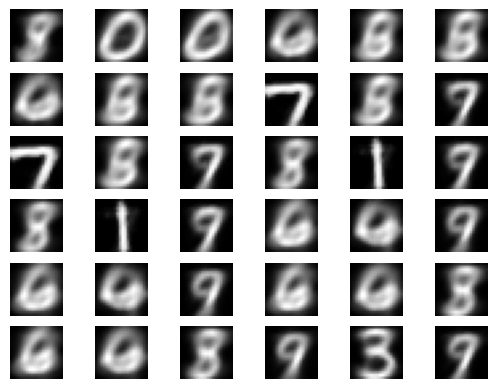

In [17]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 20, 20).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

#### （3） 亮度及对比度改变。原图片默认的亮度和对比度都为最大值，我们将亮度和对比度调小，使输入的图片呈现出稍暗的效果。大致效果如下图所示：

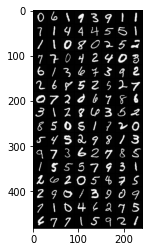

In [8]:
img,_ = next(iter(dataIter))
cj_obj = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0)
img = cj_obj(img)
img = torchvision.utils.make_grid(img)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()

此时的所有设置继承自“基本要求”中MSE Loss下的设置。唯一的变动在于在训练时采用ColorJitter函数调低了采样的图片的亮度及对比度。该函数的后面两个参数代表饱和度和色调，由于训练集中的图片为灰度图，这两个参数没有作用，因此都设置为0。可以看到训练过程中的Loss相比于正常亮度时产生了小幅度的上涨

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        # 改变图片亮度及对比度
        cj_obj = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0)
        img = cj_obj(img)
        img = torch.tensor(img,dtype=torch.float32)
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 37.413814544677734
epoch : 0 | #batch : 400 | batch average loss: 34.61432647705078
epoch[0/20] | loss:42.78048523763021
epoch : 1 | #batch : 200 | batch average loss: 28.282625198364258
epoch : 1 | #batch : 400 | batch average loss: 43.56684112548828
epoch[1/20] | loss:36.206987727864586
epoch : 2 | #batch : 200 | batch average loss: 41.00010681152344
epoch : 2 | #batch : 400 | batch average loss: 27.803691864013672
epoch[2/20] | loss:35.440457067871094
epoch : 3 | #batch : 200 | batch average loss: 40.32501220703125
epoch : 3 | #batch : 400 | batch average loss: 30.32529067993164
epoch[3/20] | loss:34.93119576009114
epoch : 4 | #batch : 200 | batch average loss: 35.8883171081543
epoch : 4 | #batch : 400 | batch average loss: 26.61086654663086
epoch[4/20] | loss:34.77134062906901
epoch : 5 | #batch : 200 | batch average loss: 41.65675354003906
epoch : 5 | #batch : 400 | batch average loss: 30.30426788330078
epoch[5/20] | loss:35.295419071

展示训练结果：我们可以看到低亮度情况下生成的手写数字质量不高，种类也较少。说明亮度和对比度确实会对手写数字生成产生影响。想要实现高效的手写数字生成需保证训练集中图片的亮度和对比度保持在一个较高的水准。

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

(0.0, 1.0, 0.0, 1.0)

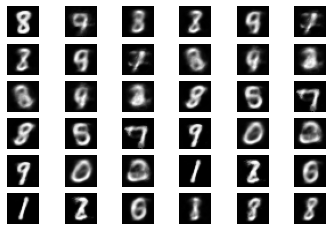

In [11]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

#### （4） 图片旋转。我们将训练集中的图片进行小角度的正向或逆向旋转。大致效果如下图所示。

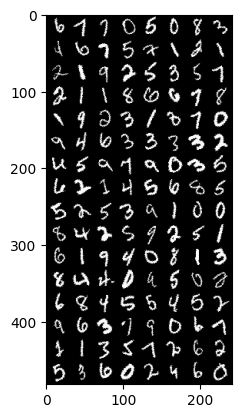

In [20]:
img,_ = next(iter(dataIter))
RR_obj = transforms.RandomRotation(90)
img = RR_obj(img)
img = torchvision.utils.make_grid(img)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()

此时的所有设置继承自“基本要求”中MSE Loss下的设置。唯一的变动在于在训练时采用RandomRotation函数对采样的图片进行了小幅度的旋转。图片将在±10°内随机选择一个角度进行旋转。可以看到训练过程中的Loss相比于正常时几乎没有变化。

In [21]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# 采用MSE loss
reconstruction_function = nn.MSELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        # 在±10的小范围内随机旋转图片
        RR_obj = transforms.RandomRotation(10)
        img = RR_obj(img)
        img = torch.tensor(img,dtype=torch.float32)
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 48.704444885253906
epoch : 0 | #batch : 400 | batch average loss: 43.096336364746094
epoch[0/20] | loss:48.33246277669271
epoch : 1 | #batch : 200 | batch average loss: 40.79308319091797
epoch : 1 | #batch : 400 | batch average loss: 40.15873336791992
epoch[1/20] | loss:41.35898403320312
epoch : 2 | #batch : 200 | batch average loss: 40.76271438598633
epoch : 2 | #batch : 400 | batch average loss: 41.62377166748047
epoch[2/20] | loss:39.99259165445964
epoch : 3 | #batch : 200 | batch average loss: 39.295433044433594
epoch : 3 | #batch : 400 | batch average loss: 40.20893096923828
epoch[3/20] | loss:39.63985419921875
epoch : 4 | #batch : 200 | batch average loss: 40.722537994384766
epoch : 4 | #batch : 400 | batch average loss: 40.2141227722168
epoch[4/20] | loss:39.38058142089844
epoch : 5 | #batch : 200 | batch average loss: 39.63422393798828
epoch : 5 | #batch : 400 | batch average loss: 42.14334487915039
epoch[5/20] | loss:39.3200036254

展示训练结果。我们可以看到此时生成的图片质量较高，种类也极多。说明如果出现生成数字质量不佳的情况，或许可以采用小角度旋转的方法来对效果起到一定的提升作用。

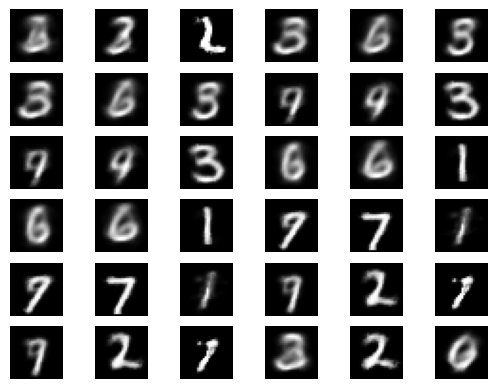

In [22]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20))
z=z.to(device)
logits = model.decode(z)  # 仅通过解码器生成图片

x_hat = torch.sigmoid(logits)  # 转换为像素范围

x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

## 5. 可视化创新

在VAE中，隐变量z到最后的输出图片之间的映射存在一定的规律，所以我们按照一定顺序来依次映射，可以展示出数字演变的过程。首先我们采用“基本要求”中BCE Loss时的设置进行训练。注意此时的VAE实例模型的隐变量z的维度应当由默认的20改为2，因为越高的维度就意味着越复杂的映射规律，低维度有助于结果的呈现。

In [23]:
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE(z_dim=2).to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差

# # 采用MSE loss
reconstruction_function = nn.BCELoss(size_average=False)

for epoch in range(epoches):
    model = model.train()
    total_loss = 0
    for i, data in enumerate(dataIter):
        # 展平并训练
        # 计算损失函数
        # 反向传播和优化
        # 输出batch信息
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(img)
        loss = loss_function(recon_batch, img, mu, log_var,reconstruction_function)
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.item() / len(img)))
        
    train_loss[epoch] = total_loss / len(dataIter.dataset)
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch]))

epoch : 0 | #batch : 200 | batch average loss: 176.92112731933594
epoch : 0 | #batch : 400 | batch average loss: 161.87240600585938
epoch[0/20] | loss:175.94643432617187
epoch : 1 | #batch : 200 | batch average loss: 167.30508422851562
epoch : 1 | #batch : 400 | batch average loss: 157.62355041503906
epoch[1/20] | loss:162.32435024414062
epoch : 2 | #batch : 200 | batch average loss: 160.3400115966797
epoch : 2 | #batch : 400 | batch average loss: 153.1708221435547
epoch[2/20] | loss:159.2874859049479
epoch : 3 | #batch : 200 | batch average loss: 165.0390625
epoch : 3 | #batch : 400 | batch average loss: 160.53704833984375
epoch[3/20] | loss:157.6541759765625
epoch : 4 | #batch : 200 | batch average loss: 157.5137176513672
epoch : 4 | #batch : 400 | batch average loss: 151.40379333496094
epoch[4/20] | loss:156.43445452473958
epoch : 5 | #batch : 200 | batch average loss: 154.63900756835938
epoch : 5 | #batch : 400 | batch average loss: 149.20404052734375
epoch[5/20] | loss:155.6590323

输出隐变量，展示数字演变。我们在0.01\~0.99的范围内均匀采样两次，作为隐变量z的两维，每次采样20个点。将采样后的隐变量进行解码，以20x20的格式输出所有采样的400张照片，即可展现出0\~9之间所有数字彼此演变生成的过程图。

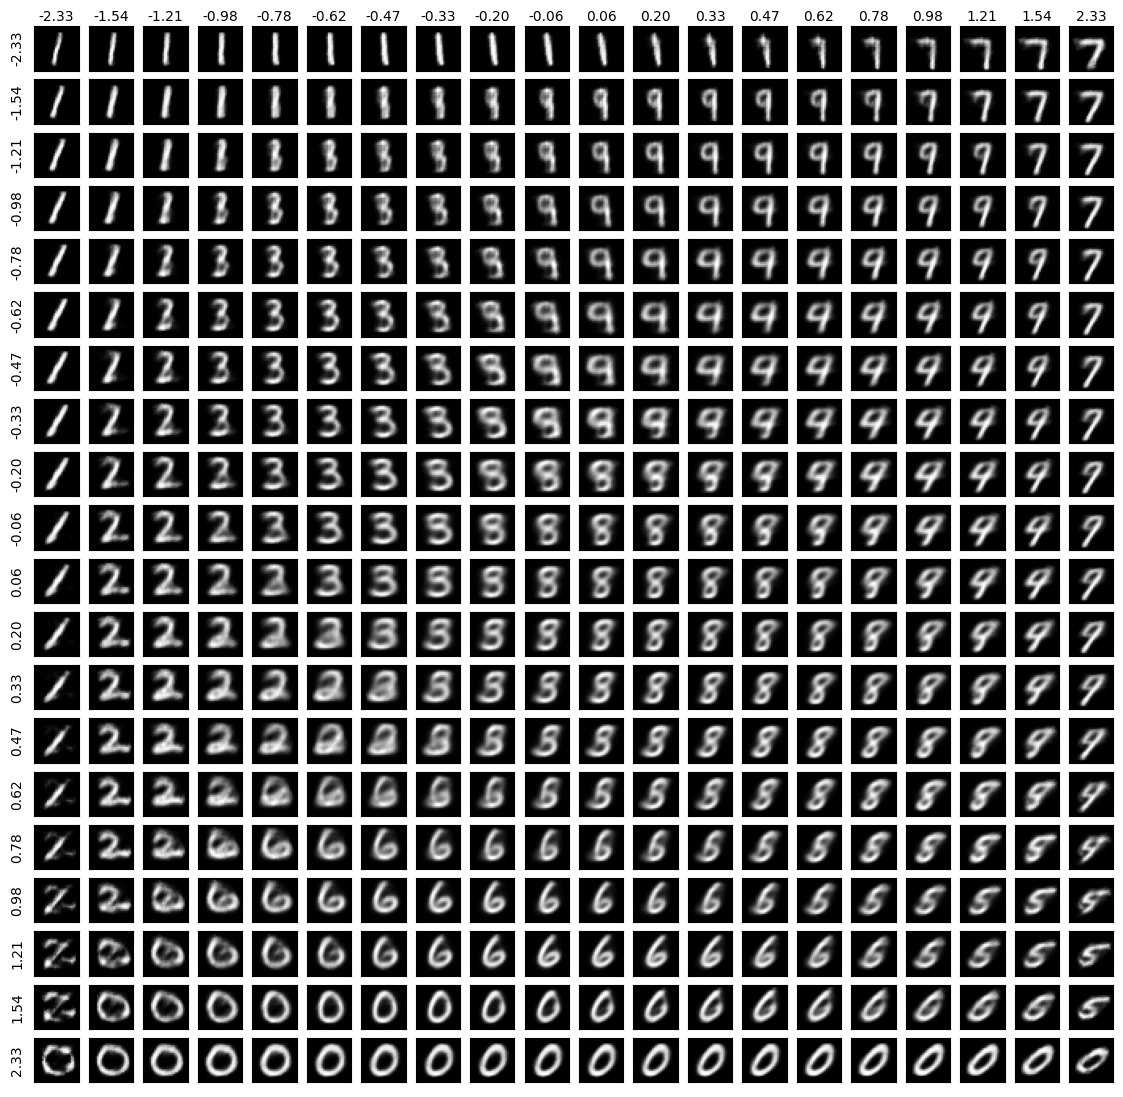

In [24]:
x = norm.ppf(np.linspace(0.01, 0.99, 20))
y = norm.ppf(np.linspace(0.01, 0.99, 20))
inputs = [(i, j) for i in x for j in y]
inputs_t = torch.tensor(inputs).to(device)
inputs_t = torch.tensor(inputs_t,dtype=torch.float32)
outputs = model.decode(inputs_t)
outputs = outputs.detach().cpu().numpy()
outputs = outputs.reshape(20, 20, 28, 28)
fig, axes = plt.subplots(20, 20, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(0, 0)
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        axes[i][j].imshow(outputs[i][j], cmap='gray')
        
        if j == 0:
            axes[i][j].set_ylabel("{:.2f}".format(y[i]))
        if i == 0:
            axes[i][j].set_xlabel("{:.2f}".format(x[j]))
            axes[i][j].xaxis.set_label_position('top') 

## 四. 成员分工
1. 许渊轶
    - MSE Loss、BCE Loss、CE Loss损失函数效果对比
    - 修改数据集（添加噪点、中心切割、亮度改变、图片旋转）
    - 可视化创新（输出隐变量）
2. 蔡玉柱
    - VAE的变分推断
    - $\beta-VAE$
    - CVAE
3. 聂志强
    - VAE基础模型搭建
    - VAE由来+优缺点
    - 生成对抗网络(GAN)